**Description:** This notebook analyse the posterior distribution of the BNN weights when applying MYIPLA to the Bayesian neural network considered in Section 3.2 of [Particle algorithms for maximum likelihood training of latent
variable models](https://juankuntz.github.io/publication/parem/) but changing the normal prior on the weights with Laplace priors that induce sparsity.

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp
import torch

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [2]:
#@title Load, subsample, and normalize MNIST dataset.

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries (pixels across whole dataset) so that they have mean zero 
# and unit standard across the dataset:
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

2024-03-23 17:24:43.880376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 17:24:43.880405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 17:24:43.881367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 17:24:44.848710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.
*   gamma: Smoothing parameter of the Moreau-Yosida envelope.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

In [3]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  
sys.path.append(project_root)

from bayesian_neural_network.algorithms import my_ipla_bnn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

We can now run the algorithms using an 80/20 training/test split of the data:

In [4]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 500  # Number of steps.
N = 100  # Number of particles.
gamma = 0.5 # Smoothing parameter

# Initialize parameter estimates:
a0 = np.array([1])  # Alpha.
b0 = np.array([1])  # Beta.

# Initialize particle cloud by sampling prior:'
w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # Input layer weights.
v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # Output layer weights.

# Run algorithms:
a_pgd, b_pgd, w_pgd, v_pgd, lppd_pgd, error_pgd = my_ipla_bnn(ltrain, itrain, ltest, 
                                                      itest, h, K, a0, b0, w0, 
                                                      v0, gamma)

100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


Sanity check, we plot the test error throught training:

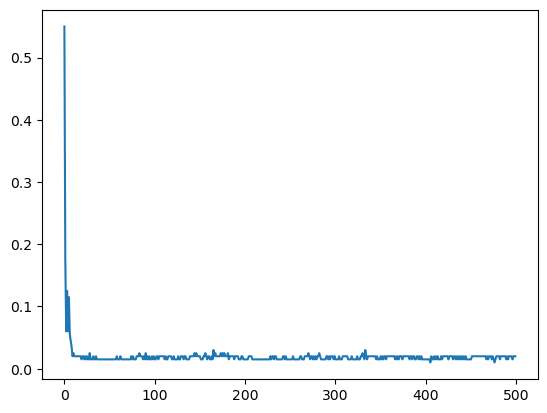

In [6]:
plt.plot(error_pgd) 

Parameter estimates

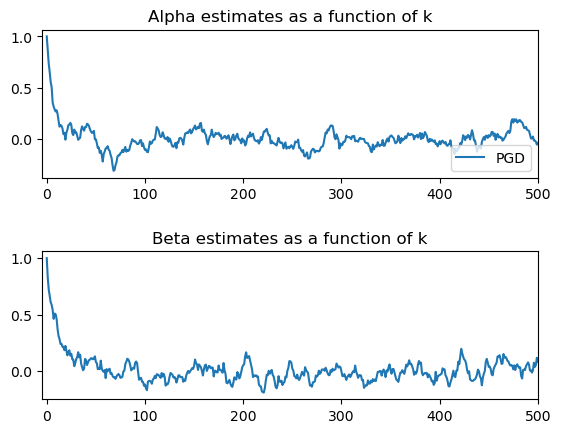

In [8]:
plt.subplot(2, 1, 1)
plt.plot(a_pgd, label='PGD') 
plt.title('Alpha estimates as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(b_pgd, label='PGD') 
plt.title('Beta estimates as a function of k')
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

Log pointwise predictive density analysis

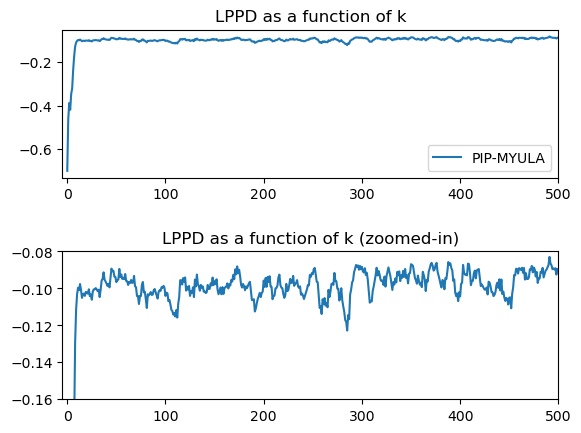

In [10]:
plt.subplot(2, 1, 1)
plt.plot(lppd_pgd, label='MYIPLA') 
plt.title('LPPD as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(lppd_pgd, label='MYIPLA') 
plt.title('LPPD as a function of k (zoomed-in)')
plt.ylim([-0.16, -0.08])
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

#### Analyse sparsity of weights

Heat map for a particle from the final cloud (describing the weights)

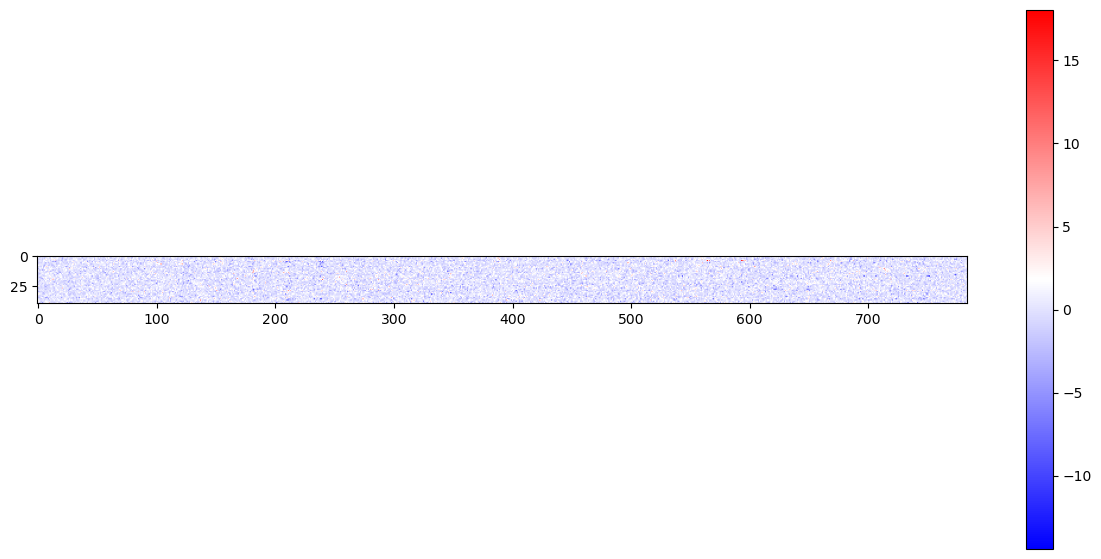

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
im = axs.imshow(w_pgd[:, :, -2], cmap='bwr')
fig.colorbar(im, ax=axs)

Heat map for the average of particles from the final cloud (describing the weights)

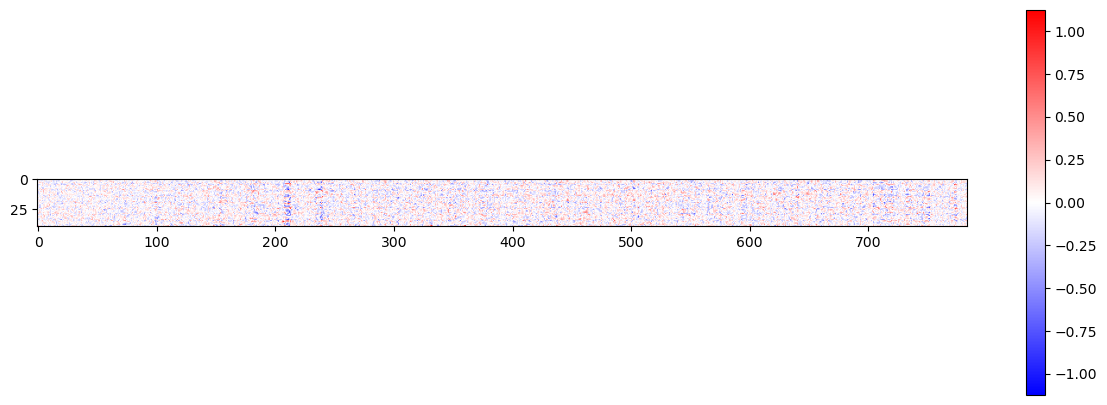

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
im = axs.imshow(np.mean(w_pgd, axis=2), cmap='bwr')
fig.colorbar(im, ax=axs)

In [13]:
# Percentage of weights with low values
print(np.sum(np.abs(np.mean(w_pgd, axis=2))<0.1)/(w_pgd[:, :, -1].size), "Percentage of w<0.1")
print(np.sum(np.abs(np.mean(v_pgd, axis=2))<0.1)/(v_pgd[:, :, -1].size), "Percentage of v<0.1")

0.40963010204081635 Percentage of w<0.1
0.2 Percentage of v<0.1


In [14]:
# Add a new dimension to the vector
a_pgd_expanded = np.expand_dims(np.mean(w_pgd, axis=2), axis=2)

print("Expanded vector:")
print(a_pgd_expanded.shape)

Expanded vector:
(40, 784, 1)


In [47]:
from bayesian_neural_network.algorithms import log_pointwise_predictive_density, test_error
lppd_last = log_pointwise_predictive_density(w_pgd, v_pgd, itest, ltest)
error_last = test_error(w_pgd, v_pgd, itest, ltest)

lppd_mean = log_pointwise_predictive_density(np.expand_dims(np.mean(w_pgd, axis=2), axis=2), 
                                                np.expand_dims(np.mean(v_pgd, axis=2), axis=2), itest, ltest)
error_mean = test_error(np.expand_dims(np.mean(w_pgd, axis=2), axis=2), 
                          np.expand_dims(np.mean(v_pgd, axis=2), axis=2), itest, ltest)

# Set to zero for compression
th = 0.2
mean_w = np.mean(w_pgd, axis=2)
ww = np.expand_dims(np.where(np.abs(mean_w)>th, mean_w, 0), axis=2)

mean_v = np.mean(v_pgd, axis=2)
vv = np.expand_dims(np.where(np.abs(mean_v)>th, mean_v, 0), axis=2)

lppd_shrink = log_pointwise_predictive_density(ww, vv, itest, ltest)

error_shrink = test_error(ww, vv, itest, ltest)

threshold = 7
lppd_shrink_2 = log_pointwise_predictive_density(np.where(np.abs(w_pgd)>threshold, w_pgd, 0), 
                                                  np.where(np.abs(v_pgd)>threshold, v_pgd, 0), itest, ltest)

error_shrink_2 = test_error(np.where(np.abs(w_pgd)>threshold, w_pgd, 0), 
                            np.where(np.abs(v_pgd)>threshold, v_pgd, 0), itest, ltest)

In [48]:
#Analysis of weights
# Percentage of weights with low values
print(np.sum(np.abs(np.mean(w_pgd, axis=2))<th)/(w_pgd[:, :, -1].size), "Percentage of w<th")
print(np.sum(np.abs(np.mean(v_pgd, axis=2))<th)/(v_pgd[:, :, -1].size), "Percentage of v<th")

0.7394132653061225 Percentage of w<th
0.475 Percentage of v<th


In [40]:
np.sum(np.abs(w_pgd)>threshold)/(w_pgd.size), np.sum(np.abs(v_pgd)>threshold)/(v_pgd.size)

(0.006448660714285714, 0.032625)

In [49]:
print(lppd_last)
print(error_last)
print(lppd_shrink, "LPPD shrinkage")
print(error_shrink, "Error shrinkage")

print(lppd_shrink_2, "LPPD shrinkage not averaged")
print((error_shrink_2), "Error shrinkage not averaged")

-0.09312425
0.015
-0.23222925 LPPD shrinkage
0.07 Error shrinkage
-0.42449042 LPPD shrinkage not averaged
0.11 Error shrinkage not averaged


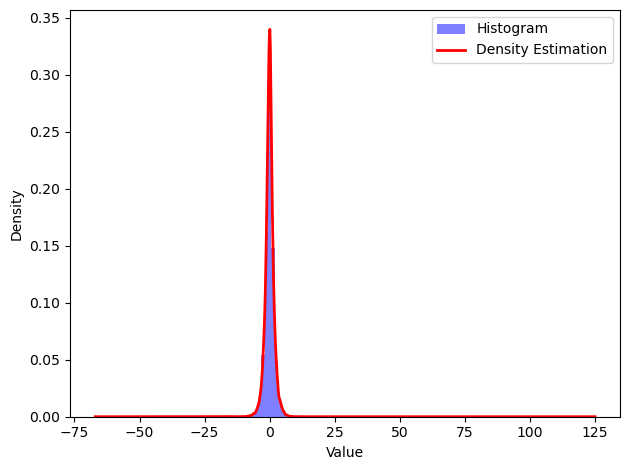

In [11]:
from scipy.stats import gaussian_kde

fig = plt.figure()

#data = np.array(np.mean(w_pgd, axis=2).flatten().tolist())
data = np.array(w_pgd[:, :, -1].ravel().tolist())
#data = w_pgd[:, :, -10].flatten()

# Prior distribution samples
data2 = np.random.laplace(0, 1, 1000)

# Step 2: Plot a Histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='b', label='Histogram')

# Step 3: Perform Density Estimation
kde = gaussian_kde(data)
#x_vals = np.linspace(min(data), max(data), 1000)
x_vals = np.linspace(-67, 125, 1000)
density_estimation = kde.evaluate(x_vals)

kde_2 = gaussian_kde(data2)
x_vals_2 = np.linspace(min(data), max(data), 1000)
density_estimation_2 = kde_2.evaluate(x_vals_2)

# Step 4: Plot the Density Estimation
plt.plot(x_vals, density_estimation, 'r-', linewidth=2, label='Density Estimation')

# Adding labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
#plt.title('Histogram and Density Estimation')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

fig.savefig("histogram_weights_laplace_new_limits.pdf", bbox_inches='tight')

#### Test error and lppd vs pruning threshold

In [7]:
from bayesian_neural_network.algorithms import log_pointwise_predictive_density, test_error

# Set to zero for compression
th_list = np.linspace(0, 1, 300)
mean_w = np.mean(w_pgd, axis=2)
mean_v = np.mean(v_pgd, axis=2)
lppd_list = []
error_list = []
for th in th_list:  
    ww = np.expand_dims(np.where(np.abs(mean_w)>th, mean_w, 0), axis=2)

    vv = np.expand_dims(np.where(np.abs(mean_v)>th, mean_v, 0), axis=2)

    lppd_shrink = log_pointwise_predictive_density(ww, vv, itest, ltest)
    lppd_list.append(lppd_shrink)

    error_shrink = test_error(ww, vv, itest, ltest)
    error_list.append(error_shrink)

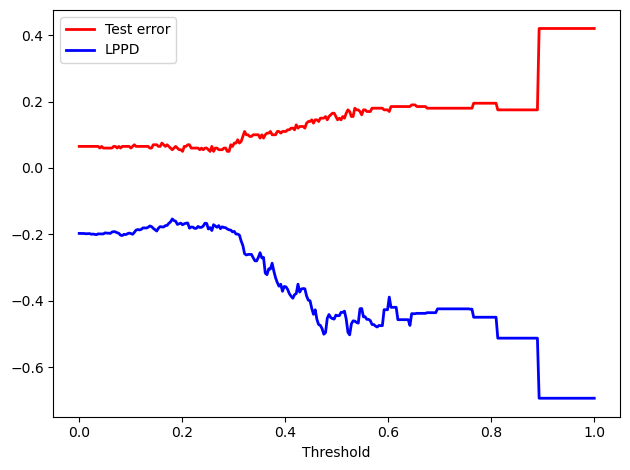

In [16]:
fig = plt.figure()

plt.plot(th_list, error_list, label='Test error', linewidth=2, color='r')
plt.plot(th_list, lppd_list, label='LPPD', linewidth=2, color = 'b')

# Adding labels and legend
plt.xlabel('Threshold')
#plt.ylabel('Density')
#plt.title('Histogram and Density Estimation')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [17]:
# Set to zero for compression
th_list = np.linspace(0, 7, 700)
lppd_list = []
error_list = []
for threshold in th_list:  

    lppd_shrink_2 = log_pointwise_predictive_density(np.where(np.abs(w_pgd)>threshold, w_pgd, 0), 
                                                  np.where(np.abs(v_pgd)>threshold, v_pgd, 0), itest, ltest)

    error_shrink_2 = test_error(np.where(np.abs(w_pgd)>threshold, w_pgd, 0), 
                            np.where(np.abs(v_pgd)>threshold, v_pgd, 0), itest, ltest)

    lppd_list.append(lppd_shrink_2)

    error_list.append(error_shrink_2)

In [41]:
#Analysis of weights
# Percentage of weights with low values
print(np.sum(np.abs(w_pgd)>7)/(w_pgd.size), "Percentage of w<th")
print(np.sum(np.abs(v_pgd)>7)/(v_pgd.size), "Percentage of v<th")

0.007251594387755102 Percentage of w<th
0.05375 Percentage of v<th


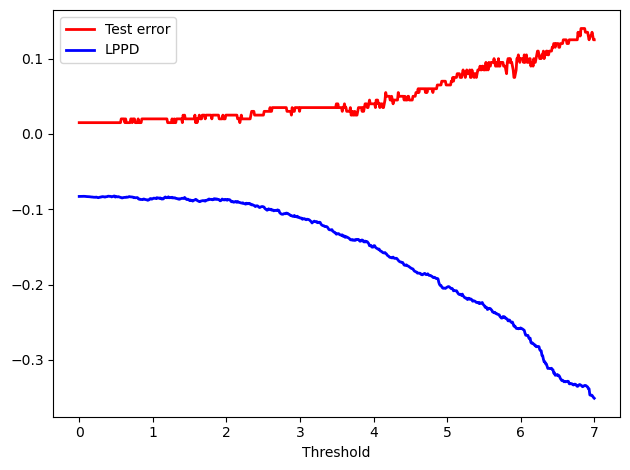

In [18]:
fig = plt.figure()

plt.plot(th_list, error_list, label='Test error', linewidth=2, color='r')
plt.plot(th_list, lppd_list, label='LPPD', linewidth=2, color = 'b')

# Adding labels and legend
plt.xlabel('Threshold')
#plt.ylabel('Density')
#plt.title('Histogram and Density Estimation')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Memory occupancy for different pruning thresholds

In [425]:
from sys import getsizeof
threshold_list = np.linspace(0, 7, 700)
memory_th_v = []
memory_th_w = []
for th in threshold_list:
    pruned_matrix_th = np.where(np.abs(v_pgd)>th, v_pgd, 0)
    dead_units_hidden_layer_th = np.sum((np.sum(pruned_matrix_th[:,:,:]==0, axis=0)==2), axis=0)
    active_units_hidden_layer_th = 40-dead_units_hidden_layer_th
    list_memory_th = []
    list_memory_2_th = []
    for i in active_units_hidden_layer_th:
        list_memory_th.append(getsizeof(np.ones((i,784)))/getsizeof(np.ones((40,784))))
        list_memory_2_th.append(getsizeof(np.ones((2,i)))/getsizeof(np.ones((2,40))))
    memory_th_w.append(np.mean(list_memory_th))
    memory_th_v.append(np.mean(list_memory_2_th))

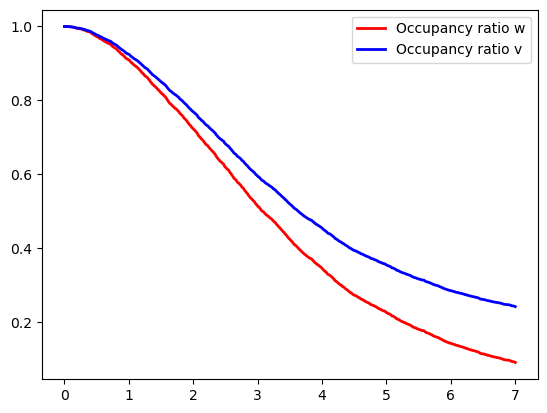

In [426]:
fig = plt.figure()
plt.plot(threshold_list, memory_th_w, label='Occupancy ratio w', linewidth=2, color='r')
plt.plot(threshold_list, memory_th_v, label='Occupancy ratio v', linewidth=2, color = 'b')
plt.legend()

In [427]:
threshold_list = np.linspace(0, 1, 500)
memory_th_v = []
memory_th_w = []
for th in threshold_list:
    pruned_matrix_th = np.where(np.abs(mean_v)>th, mean_v, 0)
    dead_units_hidden_layer_th = np.sum((np.sum(pruned_matrix_th==0, axis=0)==2))
    active_units_hidden_layer_th = 40-dead_units_hidden_layer_th
    i = active_units_hidden_layer_th
    memory_th_w.append(getsizeof(np.ones((i,784)))/getsizeof(np.ones((40,784))))
    memory_th_v.append(getsizeof(np.ones((2,i)))/getsizeof(np.ones((2,40))))

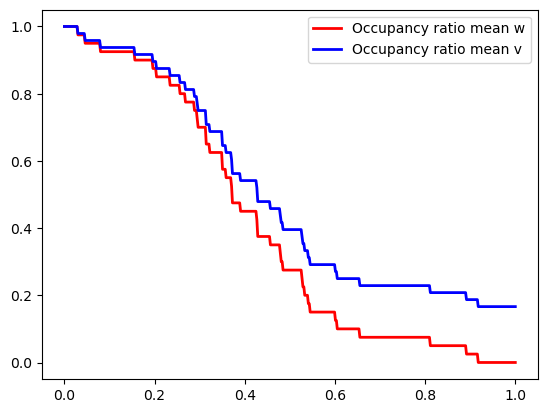

In [428]:
fig = plt.figure()
plt.plot(threshold_list, memory_th_w, label='Occupancy ratio mean w', linewidth=2, color='r')
plt.plot(threshold_list, memory_th_v, label='Occupancy ratio mean v', linewidth=2, color = 'b')
plt.legend()